In [1]:
import os
import random
from argparse import ArgumentParser

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.networks import Generator
from utils.tools import get_config, random_bbox, mask_image, is_image_file, default_loader, normalize, get_model_list

import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_PATH = "/var/tmp/namespace/hendrycks/imagenet/val/n03874599/ILSVRC2012_val_00004826.JPEG"
CHECKPOINT_PATH = "hole_benchmark/gen_00430000.pt"

In [3]:
def get_image(path, img_shape=(256, 256)):
    img = default_loader(path)
    img = transforms.Resize(img_shape)(img)
    img = transforms.CenterCrop(img_shape)(img)
    img = transforms.ToTensor()(img)
    img = normalize(img)
    img = img.unsqueeze(dim=0)
    return img

ground_truth_image = get_image(IMG_PATH) # (1, 3, 256, 256)

In [4]:
def random_mask(mask_shape=(50, 50), img_shape=(256, 256), num=1):
    """Generate a random tlhw with configuration.

    Args:
        config: Config should have configuration including img

    Returns:
        tuple: (top, left, height, width)

    """
    img_height, img_width = img_shape
    h, w = mask_shape
    maxt = img_height - h
    maxl = img_width - w
    bbox_list = []
    for i in range(num):
        t = np.random.randint(0, maxt)
        l = np.random.randint(0, maxl)
        bbox_list.append((t, l, h, w))

        
    
    return torch.tensor(bbox_list, dtype=torch.int64)


def apply_masks(bboxes, image):
    """
    image: (C, H, W)
    """
    # 0 for masked out, 1 for not masked
    mask_composite = torch.ones((1, image.shape[1], image.shape[2]))

    for t, l, h, w in bboxes:
        mask = torch.zeros_like(image)
        mask[:, t:t+h, l:l+w] = 1
        image = image * (1.0 - mask)
        mask_composite = mask_composite * (1.0 - mask[0])
    
    return image, mask_composite

tensor(0.)
tensor(1.)


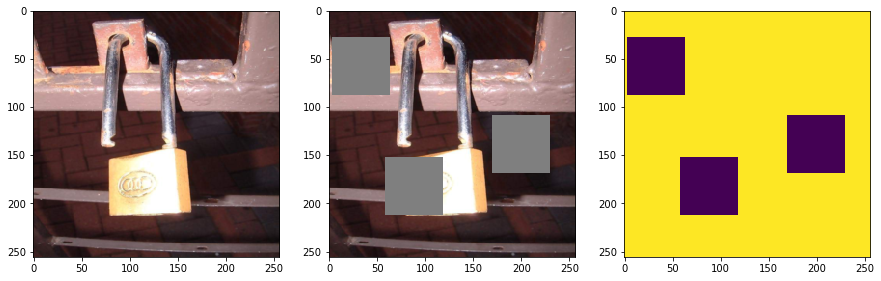

In [5]:
def show_image(image, plt=plt):
    image = (image.detach().cpu() + 1) / 2
    
    if image.shape[0] == 1:
        plt.imshow(image.squeeze(0).numpy())
    else:
        plt.imshow(image.numpy().transpose(1,2,0))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
show_image(ground_truth_image[0], ax[0])

# Make masked version
masked_image, mask = apply_masks(random_mask(num=3, mask_shape=(60, 60)), ground_truth_image[0])
show_image(masked_image, ax[1])
show_image(mask, ax[2])
print(torch.min(mask))
print(torch.max(mask))

In [6]:
netG = Generator(config={"input_dim": 3, "ngf": 32}, use_cuda=True).cuda()
netG.load_state_dict(torch.load(CHECKPOINT_PATH))
netG = nn.parallel.DataParallel(netG)

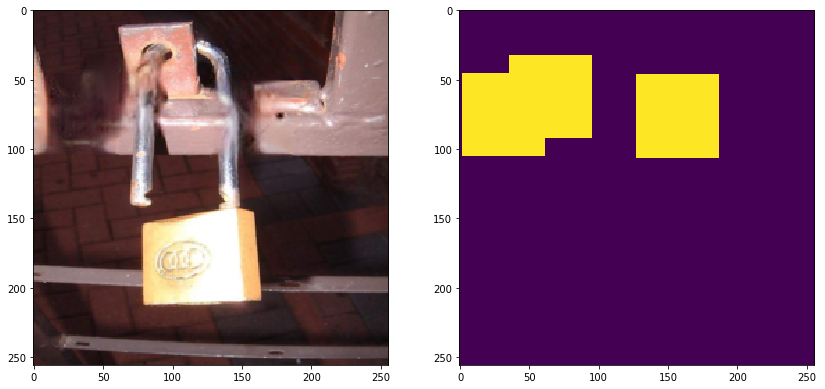

In [7]:
# Run inference
masked_image, mask = apply_masks(random_mask(num=3, mask_shape=(60, 60)), ground_truth_image[0])
input_batch = masked_image.unsqueeze(0).cuda()
input_mask_batch = mask.unsqueeze(0).cuda()
input_mask_batch = 1 - input_mask_batch

x1, x2, offset_flow = netG(input_batch, input_mask_batch)
inpainted_result = x2 * (input_mask_batch.cuda()) + input_batch * (1.0 - input_mask_batch.cuda())

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,14))
show_image(inpainted_result[0], plt=ax[0])
show_image(input_mask_batch[0], plt=ax[1])